In [1]:
# TODO
# [x] debug the 2 element method for non square triangle
# [x] add the LocalReorder to the V matrix
# [] refactor the code and structure it nicely
# [] add more elements on the triangle
# [] test the simple ODE problem -> figure out the M matrix conversion to the other side

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy.integrate import quad
from time import perf_counter as time

from tqdm import tqdm
from scipy import linalg, stats

import scipy as sp
from scipy.special import jacobi, legendre, roots_jacobi, eval_jacobi, factorial, gamma

# from tb_utils import JacobiGL, constructV, constructVx, constructD, z2x, z2x_dz, x2z, x2z_dx, evaluate_jacobi_grid, constructMinv, jacobi_p_normalisation_const
from tb_utils import *
import itertools
from scipy.sparse import diags, kron, eye, spdiags

import warnings
warnings.filterwarnings('ignore')

## Toy problem 1D

In [3]:
# eps = 0.001
eps = 0.1
x0, xN = 0, 1
g0, gN = 0, 0
# a_pde, b_pde, c_pde = -eps, -1, 0

def f(x): return np.ones(x.shape[0])

def u_exact_solution(x, eps=eps): return (np.exp(-x/eps) + (x - 1) - np.exp(-1/eps)*x)/(np.exp(-1/eps) - 1)

### Nodal Continous Galerkin - one domain

In [4]:
alpha, beta = 0, 0 # Legendere polynomials
N = 10
J = (xN - x0) / 2

z = JacobiGL(alpha=alpha, beta=beta, N=N) # z are the points in [-1,1]
D_z = constructD(z=z, alpha=alpha, beta=beta, a=-1, b=1)

M_inv = constructMinv(z=z, alpha=alpha, beta=beta, a=-1, b=1)
M = np.linalg.inv(M_inv)

L_N = (eps/J**2) * (D_z.T @ M @ D_z) - (1/J) * (M @ D_z)
L_N[0, :] = 0; L_N[0, 0] = 1
L_N[N, :] = 0; L_N[N, N] = 1
print(f"{np.linalg.cond(L_N)}")

w = 2 / (N * (N+1)) / np.power(eval_jacobi(N, alpha, beta, z), 2)
fx = w.copy()
fx[0] = g0; fx[N] = gN

u_z = linalg.solve(L_N, fx) # in nodal space

x = z2x(z=z, a=x0, b=xN)
u_x = u_z

63.117842835674146


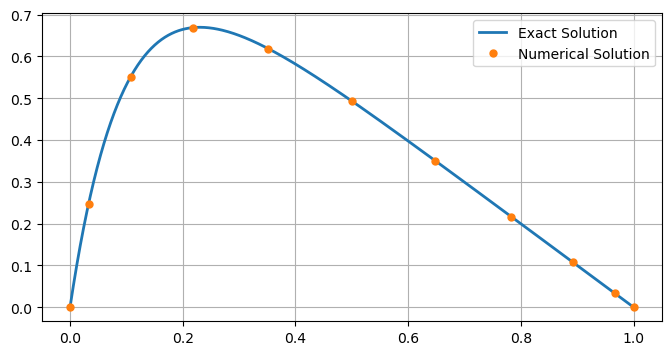

In [5]:
x_plot = np.linspace(x0, xN, 500)
u_exact_plot = u_exact_solution(x_plot, eps)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(x_plot, u_exact_plot, label="Exact Solution", linewidth=2)
ax.plot(x, u_x, 'o', label="Numerical Solution", markersize=5)
# ax[0].plot(x_eval, u_eval, linestyle='--', label="Interpolated Solution", linewidth=2)
ax.grid();
ax.legend();

### SEM - 2 domains

In [6]:
x_split = 0.1
alpha, beta = 0, 0 # Legendere polynomials
N = 10
J_1 = (x_split - x0) / 2
J_2 = (xN - x_split) / 2
print(f"{J_1 = }; {J_2 = }")

z = JacobiGL(alpha=alpha, beta=beta, N=N) # z are the points in [-1,1]
D_z = constructD(z=z, alpha=alpha, beta=beta, a=-1, b=1)
M_z_inv = constructMinv(z=z, alpha=alpha, beta=beta, a=-1, b=1)
M_z = np.linalg.inv(M_z_inv)

L_N_1 = (eps/J_1) * (D_z.T @ M_z @ D_z) - (M_z @ D_z)
L_N_1[0, :] = 0; L_N_1[0, 0] = 1
# L_N_1[N, :] = 0; L_N_1[N, N] = 1

L_N_2 = (eps/J_2) * (D_z.T @ M_z @ D_z) - (M_z @ D_z)
# L_N_2[0, :] = 0; L_N_2[0, 0] = 1
L_N_2[N, :] = 0; L_N_2[N, N] = 1

print(f"{np.linalg.cond(L_N_1) = }; {np.linalg.cond(L_N_2) = }")
# L_N = sp.linalg.block_diag(L_N_1, L_N_2)

w = 2 / (N * (N+1)) / np.power(eval_jacobi(N, alpha, beta, z), 2)
f_1 = J_1 * w.copy(); f_2 = J_2 * w.copy()
f_1[0] = g0;
f_2[N] = gN

L_N = np.zeros((2*(N+1)-1, 2*(N+1)-1))
f = np.zeros(2*(N+1)-1)

L_N[0:N+1, 0:N+1] += L_N_1
L_N[N:, N:] += L_N_2

f[0:N+1] += f_1
f[N:] += f_2

u_z = np.linalg.solve(L_N, f) # in nodal space

x_elem1 = z2x(z, x0, x_split)
x_elem2 = z2x(z, x_split, xN)
x_global = np.concatenate([x_elem1[:-1], x_elem2])

# x = z2x(z=z, a=x0, b=xN)
# u_x = u_z

J_1 = 0.05; J_2 = 0.45
np.linalg.cond(L_N_1) = np.float64(835.4060915836205); np.linalg.cond(L_N_2) = np.float64(75.17720809028569)


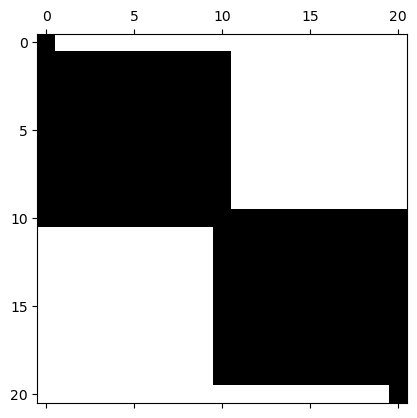

In [7]:
plt.spy(L_N)

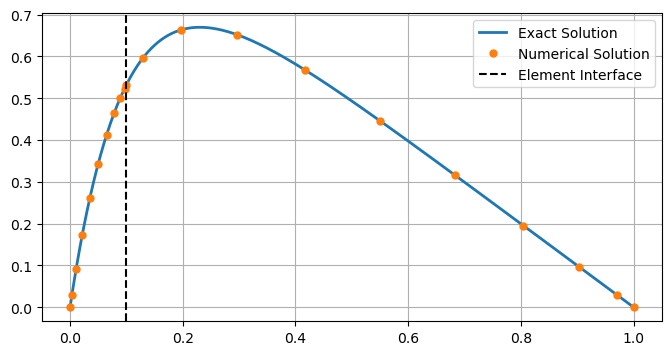

In [8]:
x_plot = np.linspace(x0, xN, 500)
u_exact_plot = u_exact_solution(x_plot, eps)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(x_plot, u_exact_plot, label="Exact Solution", linewidth=2)
ax.plot(x_global, u_z, 'o', label="Numerical Solution", markersize=5)
ax.axvline(x_split, color='k', linestyle='--', label='Element Interface')
ax.grid();
ax.legend();

In [9]:
# example 3.3 page 58 - yellow book

# V_x = np.array([0, 0.5, 1.5, 3, 2.5])/3
# EtoV = np.array([[1, 2], [2, 3], [3, 5], [5, 4]]) - 1

# print(V_x[EtoV])

# def build_FToV(EtoV, Nv):
#     # EtoV: (K,2) 1-based vertex indices
#     EtoV = np.asarray(EtoV, dtype=int)
#     K = EtoV.shape[0]
#     FToV = np.zeros((2*K, Nv), dtype=int)
#     row = 0
#     for e in range(K):
#         left, right = EtoV[e]
#         FToV[row, left-1] = 1; row += 1
#         FToV[row, right-1] = 1; row += 1
#     return FToV

# FToV = build_FToV(EtoV, Nv=5)

## Grid generation functions
based on section 6.1 in the yellow book

In [10]:
def Psi(r, s, v1, v2, v3):
    x = -0.5 * (r + s) * v1[0] + 0.5 * (1 + r) * v2[0] + 0.5 * (1 + s) * v3[0]
    y = -0.5 * (r + s) * v1[1] + 0.5 * (1 + r) * v2[1] + 0.5 * (1 + s) * v3[1]
    return x, y

def geometric_factors_own(v1, v2, v3):
    xr = (v2[0] - v1[0])/2
    yr = (v2[1] - v1[1])/2
    xs = (v3[0] - v1[0])/2
    ys = (v3[1] - v1[1])/2
    J_det = xr * ys - xs * yr
    rx = ys / J_det
    ry = -xs / J_det
    sx = -yr / J_det
    sy = xr / J_det
    matrix = np.array([[rx, ry], [sx, sy]])
    return matrix, J_det

In [11]:
def barycentric_lattice(N):
    """
    Return array of shape (M,3) with barycentric coordinates (λ1, λ2, λ3)
    for integer (i,j) ≥ 0, i+j ≤ N:
        λ1 = i / N
        λ3 = j / N
        λ2 = 1 - λ1 - λ3
    where M = (N+1)(N+2)/2 is the number of points in the lattice.
    """
    i = np.arange(N+1)
    j = np.arange(N+1)
    I, J = np.meshgrid(i, j, indexing='ij')
    mask = (I + J) <= N
    lam1 = (I[mask] / N).astype(float)
    lam3 = (J[mask] / N).astype(float)
    lam2 = 1.0 - lam1 - lam3
    return np.vstack([lam1, lam2, lam3]).T

N = 10
lattice = barycentric_lattice(N)
# print(lattice)

v1_canonical, v2_canonical, v3_canonical = np.array([-1, -1]), np.array([1, -1]), np.array([-1, 1])

def lambda2xy(lambdas, v1, v2, v3):
    x = lambdas[:, 0] * v1[0] + lambdas[:, 1] * v2[0] + lambdas[:, 2] * v3[0]
    y = lambdas[:, 0] * v1[1] + lambdas[:, 1] * v2[1] + lambdas[:, 2] * v3[1]
    return x, y

r, s = lambda2xy(lattice, v1_canonical, v2_canonical, v3_canonical)

v1, v2, v3 = np.array([-1, 1]), np.array([2, 8]), np.array([5, 7])

x, y = Psi(r, s, v1, v2, v3)

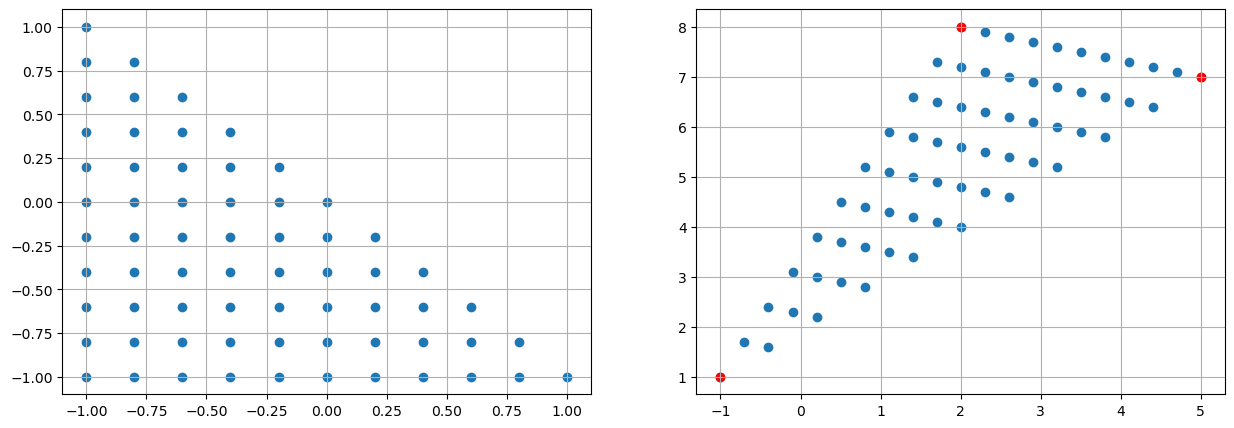

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(r, s)
ax[0].grid()
ax[1].scatter(x, y)
ax[1].scatter(v1[0], v1[1], color='r')
ax[1].scatter(v2[0], v2[1], color='r')
ax[1].scatter(v3[0], v3[1], color='r')
ax[1].grid()

In [13]:
v1_equilateral = np.array([0, 2/np.sqrt(3)])
v2_equilateral = np.array([-1, -1/np.sqrt(3)])
v3_equilateral = np.array([1, -1/np.sqrt(3)])

x, y = lambda2xy(lattice, v1_equilateral, v2_equilateral, v3_equilateral)

def equilateral2rs(x, y):
    L1 = (np.sqrt(3)*y + 1) / 3
    L2 = (-3*x - np.sqrt(3)*y + 2) / 6
    L3 = (3*x - np.sqrt(3)*y + 2) / 6
    r = -L2 + L3 - L1
    s = -L2 - L3 + L1
    return r, s

r, s = equilateral2rs(x, y)

print(np.sqrt(np.sum((v1_equilateral - v2_equilateral)**2)))
print(np.sqrt(np.sum((v2_equilateral - v3_equilateral)**2)))
print(np.sqrt(np.sum((v1_equilateral - v3_equilateral)**2)))

2.0000000000000004
2.0
2.0000000000000004


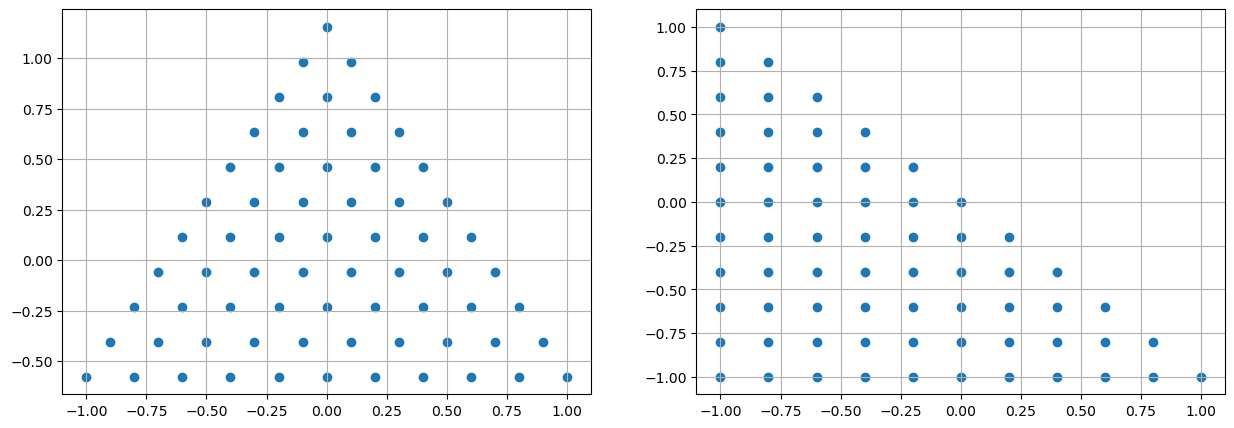

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(x, y)
ax[0].grid()
ax[1].scatter(r, s)
ax[1].grid()

In [15]:
# Chat fully
def warpfactor(N, rout, alpha=0, beta=0):
    """
    Warp factor (Warp–Blend) for order N evaluated at rout (array in [-1,1]).
    """
    rout = np.asarray(rout, dtype=float)          # size Nr

    # 1) LGL (Jacobi–Gauss–Lobatto) nodes
    r_GL = JacobiGL(alpha=alpha, beta=beta, N=N)  # size N+1

    # 2) Equidistant nodes
    req = np.linspace(-1.0, 1.0, N+1)

    # 3) Vandermonde at equidistant nodes: Veq[j,i] = P_i(req[j])
    Veq = np.column_stack([eval_jacobi(i, alpha, beta, req) for i in range(N+1)])  # (N+1)x(N+1)

    # 4) Evaluate basis at rout (Pmat[j,i] = P_i(rout[j]))
    Pmat = np.column_stack([eval_jacobi(i, alpha, beta, rout) for i in range(N+1)])  # (Nr)x(N+1)

    # 5) Lagrange basis values at rout on req nodes:
    # Veq^T Lmat^T = Pmat^T  => Lmat^T = (Veq^T)^{-1} Pmat^T
    Lmat_T = np.linalg.solve(Veq.T, Pmat.T)       # (N+1)xNr
    # Each column j: ℓ_i(rout_j)

    # 6) Displacement d_i
    disp = r_GL - req                             # (N+1,)

    # 7) Interpolate displacement
    warp = (Lmat_T.T @ disp)                      # (Nr,)

    # 8) Blend (vanish at endpoints)
    zerof = (np.abs(rout) < 1.0 - 1.0e-10)
    sf = 1.0 - (zerof * rout)**2                  # (Nr,)
    warp = warp / sf + warp * (~zerof) * (-1.0)   # when |r|≈1 force to 0

    return warp

# Example
N = 50
r_plot = np.linspace(-1, 1, 70)
w = warpfactor(N, r_plot)

# plt.scatter(r_plot, w)
# plt.plot(r_plot, r_plot, linestyle='--', color='k')

In [16]:
# Chat fully
def nodes2d(N):
    """
    Compute (x,y) warp–blend nodes in an equilateral triangle for polynomial order N.
    Returns arrays x,y of length (N+1)(N+2)/2.
    """
    if N == 0:
        # Triangle vertices (equilateral of side 2 centered)
        return np.array([0.0]), np.array([0.0])
    # Optimized alpha (same list as in original code; MATLAB 1-based → Python 0-based)
    alpopt = [0.0000, 0.0000, 1.4152, 0.1001, 0.2751, 0.9800, 1.0999,
              1.2832, 1.3648, 1.4773, 1.4959, 1.5743, 1.5770, 1.6223, 1.6258]
    alpha = alpopt[N] if N < 15 else 5/3

    Np = (N+1)*(N+2)//2
    L1 = np.zeros(Np); L2 = np.zeros(Np); L3 = np.zeros(Np)
    sk = 0
    for n in range(1, N+2):
        for m in range(1, N+3 - n):
            L1[sk] = (n-1)/N
            L3[sk] = (m-1)/N
            sk += 1
    L2 = 1.0 - L1 - L3

    # Initial equidistributed coordinates in equilateral triangle
    x = -L2 + L3
    y = (-L2 - L3 + 2*L1)/np.sqrt(3.0)

    # Blending functions
    blend1 = 4.0 * L2 * L3
    blend2 = 4.0 * L1 * L3
    blend3 = 4.0 * L1 * L2

    # Edge warp amounts
    warpf1 = warpfactor(N, L3 - L2)
    warpf2 = warpfactor(N, L1 - L3)
    warpf3 = warpfactor(N, L2 - L1)

    # Combine (edge-wise scaling factors)
    warp1 = blend1 * warpf1 * (1.0 + (alpha * L1)**2)
    warp2 = blend2 * warpf2 * (1.0 + (alpha * L2)**2)
    warp3 = blend3 * warpf3 * (1.0 + (alpha * L3)**2)

    # Accumulate deformations (rotations 0, 120°, 240°)
    x = x + 1.0*warp1 + np.cos(2*np.pi/3)*warp2 + np.cos(4*np.pi/3)*warp3
    y = y + 0.0*warp1 + np.sin(2*np.pi/3)*warp2 + np.sin(4*np.pi/3)*warp3

    return x, y

In [17]:
N = 20
x_equilateral, y_equilateral = nodes2d(N)
print(f"{x_equilateral.shape = }; {y_equilateral.shape = }")
print(f"{(N+1)*(N+2)//2 = };")

r, s = equilateral2rs(x_equilateral, y_equilateral)

# v1, v2, v3 = np.array([-1, 1]), np.array([2, 8]), np.array([5, 7])
v1, v2, v3 = np.array([-1, -1]), np.array([1, -1]), np.array([1, 3])

x, y = Psi(r, s, v1, v2, v3)

x_equilateral.shape = (231,); y_equilateral.shape = (231,)
(N+1)*(N+2)//2 = 231;


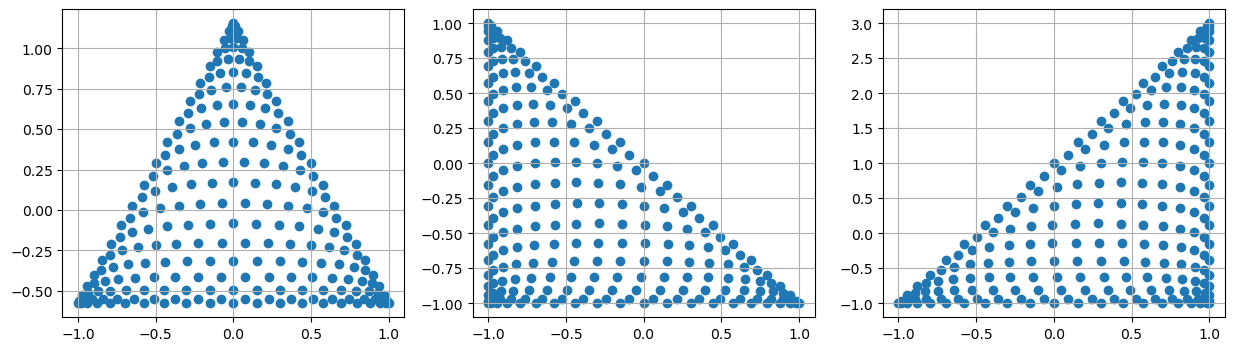

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].scatter(x_equilateral, y_equilateral)
ax[0].grid()
ax[1].scatter(r, s)
ax[1].grid()
ax[2].scatter(x, y)
ax[2].grid()

## V, M, D_x matrices

In [19]:
# y = GradJacobiP(r, 0, 0, N)
# y_2 = GradJacobiP_book(r, 0, 0, N)
# plt.plot(y - y_2)

In [20]:
def jacobi_p_normalisation_const(alpha: float, beta: float, n: int):
    "Author: Jeppe"
    return (
        2 ** (alpha + beta + 1)
        * (gamma(n + alpha + 1) * gamma(n + beta + 1))
        / (factorial(n) * (2 * n + alpha + beta + 1) * gamma(n + alpha + beta + 1))
    )

def JacobiP_orthonormal(x, alpha, beta, N):
    norm_constant = np.sqrt(jacobi_p_normalisation_const(alpha, beta, N))
    return eval_jacobi(N, alpha, beta, x) / norm_constant

# def GradJacobiP(x, alpha, beta, n):
#     if n == 0:
#         return np.zeros_like(x)
#     return 0.5*(n + alpha + beta + 1) * eval_jacobi(n-1, alpha+1, beta+1, x)

def GradJacobiP_orthonormal(x, alpha, beta, n):
    if n == 0:
        return np.zeros_like(x)
    return np.sqrt(n*(n + alpha + beta + 1)) * JacobiP_orthonormal(x, alpha+1, beta+1, n-1)

def rs2ab(r, s, tol=1e-12):
    a = np.empty_like(r, dtype=float)
    mask = np.abs(1.0 - s) > tol
    a[mask] = 2.0 * (1.0 + r[mask]) / (1.0 - s[mask]) - 1.0
    a[~mask] = -1.0
    b = s
    return a, b

def Simplex2DP_orthonormal(a, b, i, j):
    # orthonormal basis, not just orthogonal, as in the book
    h1 = JacobiP_orthonormal(a, 0, 0, i) # / np.sqrt(jacobi_p_normalisation_const(0, 0, i))
    h2 = JacobiP_orthonormal(b, 2*i + 1, 0, j) #  / np.sqrt(jacobi_p_normalisation_const(2*i + 1, 0, j))
    P = np.sqrt(2.0) * h1 * h2 * (1 - b)**i
    return P

def vandermonde2D_orthonormal(N, r, s, LocalReorder):
    a, b = rs2ab(r, s)
    num_nodes = r.shape[0]
    num_modes = (N + 1)*(N + 2)//2
    V = np.zeros((num_nodes, num_modes))
    sk = 0
    for i in range(N + 1):
        for j in range(N - i + 1):
            V[:, sk] = Simplex2DP_orthonormal(a, b, i, j)
            sk += 1
    V = V[LocalReorder, :][:, LocalReorder]
    return V

def GradSimplex2DP(a, b, id, jd):

    fa  = JacobiP_orthonormal(a, 0, 0, id)
    gb  = JacobiP_orthonormal(b, 2*id + 1, 0, jd)
    dfa = GradJacobiP_orthonormal(a, 0, 0, id)
    dgb = GradJacobiP_orthonormal(b, 2*id + 1, 0, jd)

    # r-derivative part
    if id == 0:
        dmodedr = dfa * gb  # dfa is zero
    else:
        dmodedr = dfa * gb * (0.5*(1 - b))**(id - 1)

    # s-derivative first part
    dmodeds = dfa * (gb * (0.5*(1 + a)))
    if id > 0:
        dmodeds *= (0.5*(1 - b))**(id - 1)

    # tmp term
    tmp = dgb * (0.5*(1 - b))**id
    if id > 0:
        tmp = tmp - 0.5*id*gb*(0.5*(1 - b))**(id - 1)

    dmodeds = dmodeds + fa * tmp

    # normalization
    factor = 2**(id + 0.5)
    dmodedr *= factor
    dmodeds *= factor

    return dmodedr, dmodeds


def GradVandermonde2D_orthonormal(N, r, s, LocalReorder):
    a, b = rs2ab(r, s)
    num_nodes = r.shape[0]
    num_modes = (N + 1)*(N + 2)//2
    V2Dr = np.zeros((num_nodes, num_modes))
    V2Ds = np.zeros((num_nodes, num_modes))
    sk = 0
    for i in range(N + 1):
        for j in range(N - i + 1):
            dr, ds = GradSimplex2DP(a, b, i, j)
            V2Dr[:, sk] = dr
            V2Ds[:, sk] = ds
            sk += 1
    V2Dr = V2Dr[LocalReorder, :][:, LocalReorder]
    V2Ds = V2Ds[LocalReorder, :][:, LocalReorder]
    return V2Dr, V2Ds


def Dmatrices2D(N, r, s, LocalReorder, V=None, Vr = None, Vs = None):
    if V is None:
        V = vandermonde2D_orthonormal(N, r, s, LocalReorder)
    if Vr is None or Vs is None:
        Vr, Vs = GradVandermonde2D_orthonormal(N, r, s, LocalReorder)
    Dr = np.linalg.solve(V.T, Vr.T).T
    Ds = np.linalg.solve(V.T, Vs.T).T
    return Dr, Ds


N = 20
x_equilateral, y_equilateral = nodes2d(N)
r, s = equilateral2rs(x_equilateral, y_equilateral)
LocalReorder = np.arange(r.shape[0])
V = vandermonde2D_orthonormal(N, r, s, LocalReorder) 
print(f"{np.linalg.cond(V) = }")

# Example:
V2Dr, V2Ds = GradVandermonde2D_orthonormal(N, r, s, LocalReorder)

print(f"{np.linalg.cond(V2Dr) = }")
print(f"{np.linalg.cond(V2Ds) = }")

Dr, Ds = Dmatrices2D(N, r, s, V=V, LocalReorder=LocalReorder)

print(f"{np.linalg.cond(Dr) = }")
print(f"{np.linalg.cond(Ds) = }")

np.linalg.cond(V) = np.float64(439.66112897493855)
np.linalg.cond(V2Dr) = np.float64(inf)
np.linalg.cond(V2Ds) = np.float64(inf)
np.linalg.cond(Dr) = np.float64(3.2554908574838874e+19)
np.linalg.cond(Ds) = np.float64(9.105491810823771e+18)


In [21]:
# test 1 - derivative

def u_fun(r, s): return r**2 + r*s + s      # u(r,s)
def du_dr_exact(r, s): return 2*r + s             # ∂u/∂r

u_vals = u_fun(r, s)
du_dr_true = du_dr_exact(r, s)

du_dr_num = Dr @ u_vals        # numerical derivative

err = du_dr_num - du_dr_true
print("DERIVE TEST:")
print("max |error|:", np.max(np.abs(err)))
print("L2 error:", np.sqrt(np.mean(err**2)))

# test 2 - integral
from scipy.integrate import dblquad
I2_num, I2_err = dblquad(lambda s, r: (u_fun(r, s))**2,
                         -1.0, 1.0,
                         lambda r: -1.0,
                         lambda r: -r)
L2_scipy = np.sqrt(I2_num)

M = np.linalg.inv(V @ V.T)
I_mass = u_vals.T @ M @ u_vals

print()
print("INTEGRAL TEST:")
print(f"SciPy L2_norm: {I2_num:.16e} (abs err ~ {I2_err:.1e})")
print(f"Mass L2_norm: {I_mass:.16e}")

DERIVE TEST:
max |error|: 2.6275870368408505e-11
L2 error: 2.3562785587167034e-12

INTEGRAL TEST:
SciPy L2_norm: 7.5555555555555554e-01 (abs err ~ 2.2e-14)
Mass L2_norm: 7.5555555555556486e-01


### Toy problem on triangle

In [22]:
# -∇²u = f

### test 1 - chat
def u_exact(x, y):
    return np.sin(np.pi*x)*np.sin(np.pi*y)

def f_rhs(x, y):
    return 2*np.pi**2*np.sin(np.pi*x)*np.sin(np.pi*y)  # for -Δu = f

# WORKS :(
### test 2 - Allan
# def u_exact(x, y):
#     return np.sin(4*np.pi*(x + y)) + np.cos(4*np.pi*x*y)

# def f_rhs(x, y):
#     return 32*np.pi**2*np.sin(4*np.pi*(x + y)) + 16*np.pi**2*(x**2 + y**2)*np.cos(4*np.pi*x*y)

# def u_exact_tri(r, s, v1, v2, v3):
#     x, y = Psi(r, s, v1, v2, v3)
#     return u_exact(x, y)

# def f_rhs_tri(r, s, v1, v2, v3):
#     x, y = Psi(r, s, v1, v2, v3)
#     return f_rhs(x, y)

In [23]:
def GeometricFactors2D(x, y, Dr, Ds):
    """
    Compute metric terms rx,sx,ry,sy and Jacobian J at nodal points.
    x,y: (Np,) physical coordinates
    Dr, Ds: (Np,Np) differentiation matrices wrt reference (r,s)
    Returns rx, sx, ry, sy, J (each (Np,))
    """
    xr = Dr @ x
    xs = Ds @ x
    yr = Dr @ y
    ys = Ds @ y
    J = xr * ys - xs * yr
    rx = ys / J
    sx = -yr / J
    ry = -xs / J
    sy = xr / J
    return rx, sx, ry, sy, J

def Dmatrices2D_xy(Dr, Ds, rx, sx, ry, sy):
    D_x = rx[:, None] * Dr + sx[:, None] * Ds
    D_y = ry[:, None] * Dr + sy[:, None] * Ds
    return D_x, D_y

# def Dmatrices2D_xy_second(Dr, Ds, rx, sx, ry, sy):
#     D_x = np.diag(rx) @ Dr + np.diag(sx) @ Ds
#     D_y = np.diag(ry) @ Dr + np.diag(sy) @ Ds
#     return D_x, D_y

def solve_toy_pde(N, v1_test, v2_test, v3_test, u_exact = u_exact, f_rhs = f_rhs):

    x_equilateral, y_equilateral = nodes2d(N)
    r, s = equilateral2rs(x_equilateral, y_equilateral)
    x, y = Psi(r, s, v1_test, v2_test, v3_test)
    u_true = u_exact(x, y)
    f_test = f_rhs(x, y)

    V = vandermonde2D_orthonormal(N, r, s)
    Dr, Ds = Dmatrices2D(N, r, s, V=V)

    rx, sx, ry, sy, J = GeometricFactors2D(x, y, Dr, Ds)
    Dx, Dy = Dmatrices2D_xy(Dr, Ds, rx, sx, ry, sy)
    
    M_inv_canonical = V @ V.T
    M_inv = (1.0 / J)[:, None] * M_inv_canonical
    M = J[:, None] * np.linalg.inv(M_inv_canonical)

    # diag(J_k) cancels out, but we choose to put it into M and M_inv directly
    # QUESTION: why is the other one not working?????
    # L_N = M_inv @ (Dx.T @ M @ Dx + Dy.T @ M @ Dy)
    L_N = Dx.T @ M @ Dx + Dy.T @ M @ Dy
    f_test = M @ f_test

    # for imposing BC on the triangle
    def face_masks_triangle(r, s, tol=1e-10):
        fmask1 = np.where(np.abs(s + 1.0) < tol)[0]          # s = -1
        fmask2 = np.where(np.abs(r + s) < tol)[0]            # r + s = 0
        fmask3 = np.where(np.abs(r + 1.0) < tol)[0]          # r = -1
        return fmask1, fmask2, fmask3

    fmask1, fmask2, fmask3 = face_masks_triangle(r, s, tol=1e-10)

    Fmask = np.concatenate([fmask1, fmask2, fmask3])        # indices of all face nodes

    for idx in Fmask:
        L_N[idx, :] = 0
        L_N[idx, idx] = 1
        f_test[idx] = u_true[idx]

    # L_N = M_inv @ L_N

    # for idx in Fmask:
    #     L_N[idx, :] = 0
    #     L_N[idx, idx] = 1
    #     f_test[idx] = u_true[idx]

    u_num = linalg.solve(L_N, f_test)
    err = u_num - u_true
    L2_norm_error = np.sqrt(err @ M @ err)
    # print(L2_norm_error)

    return L2_norm_error, u_num, u_true, x, y


node_testing_coord = 1.5
V_x = np.array([-1, 1, node_testing_coord, -1])
V_y = np.array([-1, -1, node_testing_coord, 1])
EtoV = np.array([[1, 2, 4],
                [2, 3, 4]]) - 1

n_element = 1
x_vertex_n, y_vertex_n = V_x[EtoV[n_element, :]], V_y[EtoV[n_element, :]]
v1_n = np.array([x_vertex_n[0], y_vertex_n[0]])
v2_n = np.array([x_vertex_n[1], y_vertex_n[1]])
v3_n = np.array([x_vertex_n[2], y_vertex_n[2]])

# v1_test, v2_test, v3_test = np.array([-1, -1]), np.array([1, -1]), np.array([-1, 1])
# v1_test, v2_test, v3_test = np.array([-1, 1]), np.array([2, 8]), np.array([5, 7])
# v1_n, v2_n, v3_n = np.array([-1, -1]), np.array([1, -1]), np.array([1, 3])

print(f"{v1_n = }; {v2_n = }; {v3_n = }")

N = 20
L2_norm_error, u_num, u_true, x, y = solve_toy_pde(
    N=N, v1_test = v1_n, v2_test = v2_n, v3_test = v3_n,
    u_exact=u_exact, f_rhs=f_rhs
)

print(f"{L2_norm_error = }")

plt.plot(u_num, label = "Numerical Solution");
plt.plot(u_true, label = "Exact Solution");
plt.legend();
plt.grid();

v1_n = array([ 1., -1.]); v2_n = array([1.5, 1.5]); v3_n = array([-1.,  1.])


TypeError: vandermonde2D_orthonormal() missing 1 required positional argument: 'LocalReorder'

In [24]:
N_array = np.arange(5, 35)
results_array = np.zeros(N_array.shape[0])
for i, N_tmp in enumerate(tqdm(N_array)):
    err, u_num, u_true, x, y = solve_toy_pde(N_tmp, v1_n, v2_n, v3_n)
    results_array[i] = err

  0%|          | 0/30 [00:00<?, ?it/s]

TypeError: vandermonde2D_orthonormal() missing 1 required positional argument: 'LocalReorder'

In [ ]:
f

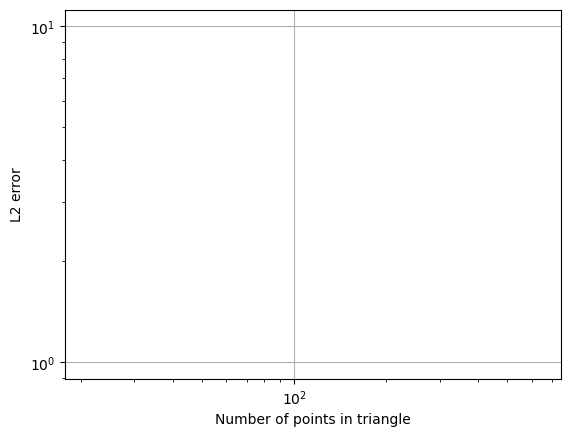

In [25]:
M_points_array = (N_array + 1)*(N_array + 2)//2

plt.loglog(M_points_array, results_array, 'o-')
plt.grid();
plt.xlabel("Number of points in triangle");
plt.ylabel("L2 error");

## Toy problem 2D

### square = 2 triangles

In [26]:
node_testing_coord_1 = 1
# node_testing_coord_2 = -0.9
# node_testing_coord_1 = 1
node_testing_coord_2 = -1
V_x = np.array([node_testing_coord_2, 1, node_testing_coord_1, -1])
V_y = np.array([node_testing_coord_2, -1, node_testing_coord_1, 1])
EtoV = np.array([[1, 2, 4],
                [2, 3, 4]]) - 1

In [27]:
# from mesh import create_2d_circle

# mesh2 = create_2d_circle(
#     radius=1.0,
#     origin=(0.0, 0.0),
#     mesh_size=1
# )
# mesh2.plot()

# V_x = mesh2.V_x
# V_y = mesh2.V_y
# EtoV = mesh2.EtoV

In [28]:
v1, v2, v3 = EtoV[:, 0], EtoV[:, 1], EtoV[:, 2]

N = 12
x_equilateral, y_equilateral = nodes2d(N)
r, s = equilateral2rs(x_equilateral, y_equilateral)

R = np.asarray(r)[:, None]  # (Np,1)
S = np.asarray(s)[:, None]  # (Np,1)

x_full = 0.5 * (-(R + S) * V_x[v1] + (1.0 + R) * V_x[v2] + (1.0 + S) * V_x[v3])
y_full = 0.5 * (-(R + S) * V_y[v1] + (1.0 + R) * V_y[v2] + (1.0 + S) * V_y[v3])

print(f"{x_full.shape = }")

def face_masks_triangle(r, s, tol=1e-10):
    fmask1 = np.where(np.abs(s + 1.0) < tol)[0]          # s = -1
    fmask2 = np.where(np.abs(r + s) < tol)[0]            # r + s = 0
    fmask3 = np.where(np.abs(r + 1.0) < tol)[0]          # r = -1
    return fmask1, fmask2, fmask3

fmask1, fmask2, fmask3 = face_masks_triangle(r, s, tol=1e-10)
# Fmask = np.concatenate([fmask1, fmask2, fmask3])        # indices of all face nodes
# Fx = x[Fmask]; Fy = y[Fmask]

Mp = s.shape[0]
Mpf = N

f_interior = np.setdiff1d(np.arange(0, Mp-1), np.concatenate([fmask1, fmask2, fmask3]))

x_full.shape = (91, 2)


[[-1 -1]
 [ 1 -1]
 [-1  1]]


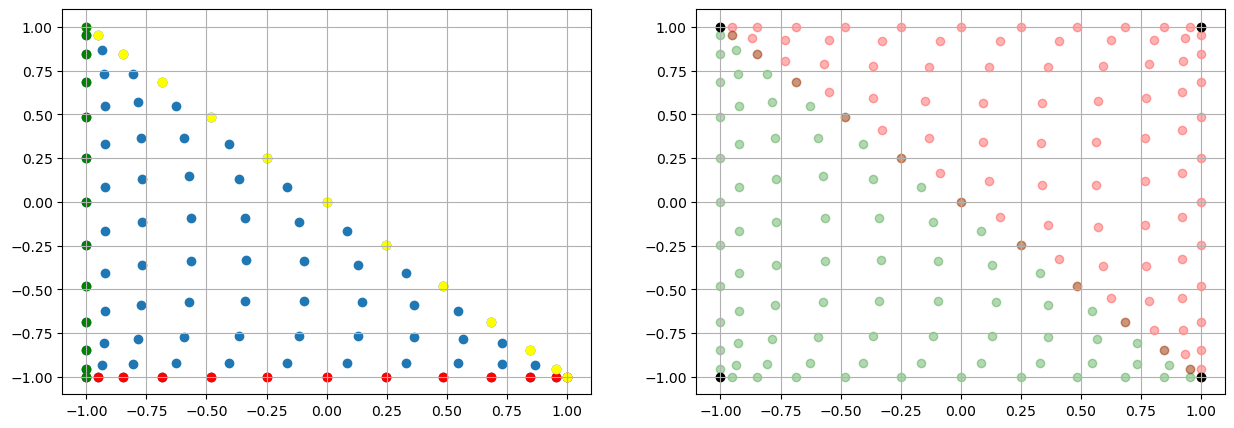

In [29]:
# array of size (3, 2) contining (v1, v2, v3)
V1 = np.vstack([V_x[EtoV[0, :]], V_y[EtoV[0, :]]]).T
V2 = np.vstack([V_x[EtoV[1, :]], V_y[EtoV[1, :]]]).T
print(V1)

x1, y1 = Psi(r, s, V1[0, :], V1[1, :], V1[2, :])
x2, y2 = Psi(r, s, V2[0, :], V2[1, :], V2[2, :])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(r, s)
# ax[0].scatter(r[Fmask], s[Fmask], color = "red")
ax[0].scatter(r[fmask1], s[fmask1], color = "red")
ax[0].scatter(r[fmask2], s[fmask2], color = "yellow")
ax[0].scatter(r[fmask3], s[fmask3], color = "green")
ax[0].grid()
ax[1].scatter(x1, y1, color = "green", alpha = 0.3)
ax[1].scatter(x2, y2, color = "red", alpha = 0.3)
ax[1].scatter(V_x, V_y, color = "black")
ax[1].grid()

In [30]:
# order: vertex, edges, interior
# WHY is here fmask3 reversed?
LocalReorder = np.concatenate([
    np.array([0, Mpf, Mp -1]),
    fmask1[1:Mpf],            # fid1(2:Mpf-1)
    fmask2[1:Mpf],            # fid2(2:Mpf-1)
    fmask3[Mpf-1:0:-1],       # fid3(Mpf-1:-1:2)
    f_interior
])
print(LocalReorder.shape[0])
assert LocalReorder.shape[0] == Mp

x_full = x_full[LocalReorder, :]
y_full = y_full[LocalReorder, :]

r = r[LocalReorder]
s = s[LocalReorder]

print(fmask3[Mpf-1:0:-1])

LocalReorder

91
[88 85 81 76 70 63 55 46 36 25 13]


array([ 0, 12, 90,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 24, 35, 45,
       54, 62, 69, 75, 80, 84, 87, 89, 88, 85, 81, 76, 70, 63, 55, 46, 36,
       25, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30,
       31, 32, 33, 34, 37, 38, 39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51,
       52, 53, 56, 57, 58, 59, 60, 61, 64, 65, 66, 67, 68, 71, 72, 73, 74,
       77, 78, 79, 82, 83, 86])

In [31]:
print(Mpf, Mp)

12 91


In [32]:
# # Correct reordering logic
# id_v1 = fmask1[0]
# id_v2 = fmask1[-1]
# id_v3 = fmask3[0]

# # Edge interiors (exclude the first and last node of the face masks)
# id_e1 = fmask1[1:-1]
# id_e2 = fmask2[1:-1]
# id_e3 = fmask3[1:-1]

# # order: Vertices, Edges (Interior), Element Interior
# LocalReorder = np.concatenate([
#     np.array([id_v1, id_v2, id_v3]),
#     id_e1,            # Edge 1: v1 -> v2
#     id_e2,            # Edge 2: v2 -> v3
#     id_e3[::-1],      # Edge 3: v3 -> v1 (Reversed to v1 -> v3 for assembly consistency)
#     f_interior
# ])

# print(f"Total nodes per element: {Mp}")
# print(f"Reorder array size: {LocalReorder.shape[0]}")
# assert LocalReorder.shape[0] == Mp

# # Apply reordering to local coordinates
# x_full = x_full[LocalReorder, :]
# y_full = y_full[LocalReorder, :]

# r = r[LocalReorder]
# s = s[LocalReorder]

## Global assembly

In [33]:
def tiConnect2D(EToV):
    import numpy as np
    from scipy.sparse import coo_matrix, eye

    EToV = np.asarray(EToV, dtype=int)
    K = EToV.shape[0]
    Nfaces = 3
    vn = np.array([[0,1],[1,2],[0,2]])  # local faces
    Nv = EToV.max()+1  # assume 0-based
    TotalFaces = K * Nfaces

    rows = []
    cols = []
    data = []
    sk = 0
    for k in range(K):
        for f in range(Nfaces):
            v0, v1 = EToV[k, vn[f]]
            rows.extend([sk, sk])
            cols.extend([v0, v1])
            data.extend([1, 1])
            sk += 1
    SpFToV = coo_matrix((data, (rows, cols)), shape=(TotalFaces, Nv)).tocsr()
    SpFToF = SpFToV @ SpFToV.T - 2 * eye(TotalFaces, format='csr')

    coo = SpFToF.tocoo()
    mask = coo.data == 2
    faces1 = coo.row[mask]
    faces2 = coo.col[mask]

    element1 = faces1 // Nfaces
    face1 = faces1 % Nfaces
    element2 = faces2 // Nfaces
    face2 = faces2 % Nfaces

    EToE = np.tile(np.arange(K)[:, None], (1, Nfaces))
    EToF = np.tile(np.arange(Nfaces)[None, :], (K, 1))
    for e1, f1, e2, f2 in zip(element1, face1, element2, face2):
        EToE[e1, f1] = e2
        EToF[e1, f1] = f2

    return EToE, EToF

EtoE, EToF = tiConnect2D(EtoV)

print(f"{EtoV = }")
print(f"{EtoE = }")
print(f"{EToF = }")

EtoV = array([[0, 1, 3],
       [1, 2, 3]])
EtoE = array([[0, 1, 0],
       [1, 1, 0]])
EToF = array([[0, 2, 2],
       [0, 1, 1]])


In [34]:
# Allan FEM book: Algo 14
def build_global_map(P, EtoV, EtoE, EToF):
    EtoV = np.asarray(EtoV, dtype=int)
    EtoE = np.asarray(EtoE, dtype=int)
    EToF = np.asarray(EToF, dtype=int)
    K = EtoV.shape[0]
    Nfaces = 3
    MP = (P + 1) * (P + 2) // 2
    Mpf = P + 1
    face_interior_count = Mpf - 2          # P-1
    interior_count = (P - 1) * (P - 2) // 2
    Nv = EtoV.max() + 1                    # zero-based vertex count
    C = np.zeros((K, MP), dtype=int)
    gidx = Nv
    for n in range(K):
        C[n, :Nfaces] = EtoV[n, :Nfaces]
        # faces
        for i in range(Nfaces):
            start = Nfaces + i * face_interior_count
            end = start + face_interior_count
            if face_interior_count > 0:
                if EtoE[n, i] >= n:  # new or boundary
                    C[n, start:end] = np.arange(gidx, gidx + face_interior_count)
                    gidx += face_interior_count
                else:
                    k_neighbor = EtoE[n, i]
                    f_neighbor = EToF[n, i]
                    n_start = Nfaces + f_neighbor * face_interior_count
                    n_end = n_start + face_interior_count
                    C[n, start:end] = C[k_neighbor, n_start:n_end][::-1]
        # interior
        if interior_count > 0:
            int_start = Nfaces + Nfaces * face_interior_count
            int_end = MP
            C[n, int_start:int_end] = np.arange(gidx, gidx + interior_count)
            gidx += interior_count
    return C, gidx

C, gidx = build_global_map(N, EtoV, EtoE, EToF)

In [35]:
# simple 2 elements triangle
print(r.shape[0] * 2 - fmask1.shape[0])
print(gidx)
print(C.shape)
print(Mp)

169
169
(2, 91)
91


In [36]:
# chat fully
def build_global_coords(C, x_elem, y_elem):
    # x_elem, y_elem: list/array of shape (K, Mp) with element-local coords
    K, Mp = C.shape
    gidx = int(C.max()) + 1
    xg = np.full(gidx, np.nan)
    yg = np.full(gidx, np.nan)
    for k in range(K):
        g = C[k]               # global ids for element k
        xk = x_elem[k]         # (Mp,)
        yk = y_elem[k]
        # scatter with consistency check
        for i, gi in enumerate(g):
            if np.isnan(xg[gi]):
                xg[gi] = xk[i]; yg[gi] = yk[i]
            else:
                # shared nodes should match
                assert np.allclose([xg[gi], yg[gi]], [xk[i], yk[i]])
    return xg, yg

x_global, y_global = build_global_coords(C.T, x_full, y_full)

In [37]:
def apply_local_reorder_to_faces(faces_local, LocalReorder=None):
    """
    Map face masks (built in canonical local ordering) to a reordered local DOF ordering.
    faces_local: list of 3 arrays (local node indices for each face)
    LocalReorder: 1D permutation of length Mp (new_order = old[LocalReorder]).
    """
    if LocalReorder is None:
        return faces_local
    LocalReorder = np.asarray(LocalReorder, dtype=int)
    inv = np.empty_like(LocalReorder)
    inv[LocalReorder] = np.arange(LocalReorder.size)
    return [inv[np.asarray(f, dtype=int)] for f in faces_local]

def boundary_nodes_from_connectivity(EToE, C, faces_local, LocalReorder=None):
    """
    Collect ONLY domain-boundary global DOF indices (no interior edges).

    EToE: (K,3) element-to-element connectivity
          boundary faces are marked as self (e) or sentinel (0 or -1), depending on convention.
    C:    (K,Mp) local-to-global map (0-based)
    faces_local: list of 3 arrays of local node indices per face, matching EToE's local face order
                 e.g. [(1,2),(2,3),(3,1)] masks built on your reference nodes.
    LocalReorder: optional 1D permutation of local DOF ordering used in C and element operators.

    Returns:
      bd_nodes: unique sorted global DOF indices on the outer boundary
      bd_faces: list of arrays with global DOFs per boundary face occurrence (one per boundary face)
    """
    EToE = np.asarray(EToE, dtype=int)
    C    = np.asarray(C, dtype=int)
    K, Nfaces = EToE.shape
    assert Nfaces == 3

    # map face masks if local DOFs were reordered
    faces_local = apply_local_reorder_to_faces(faces_local, LocalReorder)

    # Determine boundary faces across common conventions
    eidx = np.arange(K)[:, None]
    if EToE.min() >= 1:       # 1-based elements, boundary often as self=e+1 or 0
        is_self = (EToE == (eidx + 1))
        is_bdy = is_self | (EToE == 0)
    else:                     # 0-based elements, boundary often as self=e or -1
        is_self = (EToE == eidx)
        is_bdy = is_self | (EToE == -1)

    bd_faces = []
    for e in range(K):
        for f in range(3):
            if is_bdy[e, f]:
                bd_faces.append(C[e, faces_local[f]])

    bd_nodes = np.unique(np.concatenate(bd_faces)) if bd_faces else np.array([], dtype=int)
    return bd_nodes, bd_faces

# Example usage:
# faces_local must match your local face order (e.g., [s=-1, r+s=0, r=-1] or [(1,2),(2,3),(3,1)])
faces_local = [fmask1, fmask2, fmask3]
bd_nodes, bd_faces = boundary_nodes_from_connectivity(EtoE, C, faces_local, LocalReorder=LocalReorder)

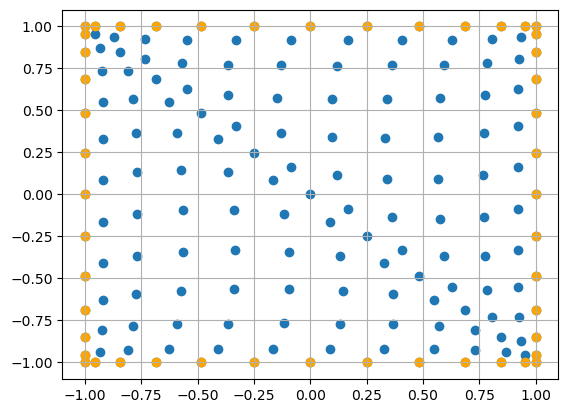

In [38]:
# tol=1e-12
# left   = np.where(np.abs(x_global + 1.0) < tol)[0]
# right  = np.where(np.abs(x_global - 1.0) < tol)[0]
# bottom = np.where(np.abs(y_global + 1.0) < tol)[0]
# top    = np.where(np.abs(y_global - 1.0) < tol)[0]
# bd_all = np.unique(np.concatenate([left, right, bottom, top]))

plt.scatter(x_global, y_global)
# plt.scatter(x_global[bd_all], y_global[bd_all], color='red');
plt.scatter(x_global[bd_nodes], y_global[bd_nodes], color='orange');
plt.grid();

# import numpy as np
# from scipy.spatial import ConvexHull
# points = np.vstack([x_global, y_global]).T
# hull = ConvexHull(points)
# hull_indices = hull.vertices

# plt.scatter(x_global, y_global)
# plt.scatter(x_global[hull_indices], y_global[hull_indices], color='red');

In [71]:
# def face_masks_triangle(r, s, tol=1e-10):
#     fmask1 = np.where(np.abs(s + 1.0) < tol)[0]          # s = -1
#     fmask2 = np.where(np.abs(r + s) < tol)[0]            # r + s = 0
#     fmask3 = np.where(np.abs(r + 1.0) < tol)[0]          # r = -1
#     Fmask = np.concatenate([fmask1, fmask2, fmask3])        # indices of all face nodes
#     return Fmask

def prepare_general_operators(N, LocalReorder):

    x_equilateral, y_equilateral = nodes2d(N)
    r, s = equilateral2rs(x_equilateral, y_equilateral)
    r_reordered = r[LocalReorder]
    s_reordered = s[LocalReorder]
    V = vandermonde2D_orthonormal(N, r, s, LocalReorder=LocalReorder)
    Vr, Vs = GradVandermonde2D_orthonormal(N, r, s, LocalReorder)
    Dr, Ds = Dmatrices2D(N, r, s, LocalReorder=LocalReorder, V=V, Vr=Vr, Vs=Vs)
    M_inv_canonical = V @ V.T
    M_canonical = np.linalg.inv(M_inv_canonical)
    
    return r_reordered, s_reordered, Dr, Ds, M_canonical, V, Vr, Vs
    
def get_n_element_operators(r, s, Dr, Ds, M_canonical, v1_n, v2_n, v3_n):

    x_n, y_n = Psi(r, s, v1_n, v2_n, v3_n)
    rx, sx, ry, sy, J = GeometricFactors2D(x_n, y_n, Dr, Ds)
    M = J[:, None] * M_canonical
    Dx, Dy = Dmatrices2D_xy(Dr, Ds, rx, sx, ry, sy)

    return Dx, Dy, M, x_n, y_n

In [72]:
N_elements = C.shape[0]
print(f"{N_elements = }")

A_full = np.zeros((gidx, gidx))
b_full = np.zeros(gidx)

r, s, Dr, Ds, M_canonical, V, Vr, Vs = prepare_general_operators(N, LocalReorder=LocalReorder)

# Allan FEM book: Algo 15, 16
for n_element in range(N_elements):

    x_vertex_n, y_vertex_n = V_x[EtoV[n_element, :]], V_y[EtoV[n_element, :]]
    v1_n = np.array([x_vertex_n[0], y_vertex_n[0]])
    v2_n = np.array([x_vertex_n[1], y_vertex_n[1]])
    v3_n = np.array([x_vertex_n[2], y_vertex_n[2]])

    Dx, Dy, M, x_n, y_n = get_n_element_operators(
        r=r, s=s, Dr=Dr, Ds=Ds, M_canonical=M_canonical,
        v1_n=v1_n, v2_n=v2_n, v3_n=v3_n
    )

    # the logic of PDE happens here
    L_N = Dx.T @ M @ Dx + Dy.T @ M @ Dy

    # L_N = L_N[LocalReorder, :][:, LocalReorder]
    # M = M[LocalReorder, :][:, LocalReorder]

    # filling A_full
    for j in range(Mp):
        for i in range(Mp):
            # exploit symmetry, not working
            # if C[n_element, j] >= C[n_element, i]:
            A_full[C[n_element, i], C[n_element, j]] += L_N[i, j]

    # filling b_full
    for j in range(Mp):
        jj = C[n_element, j]
        # which one is correct here? not specification in the algo FEM book
        x_j = x_global[jj]
        y_j = y_global[jj]
        # x_j = x_n[j]
        # y_j = y_n[j]
        for i in range(Mp):
            ii = C[n_element, i]
            b_full[ii] += M[i, j] * f_rhs(x_j, y_j)

N_elements = 2


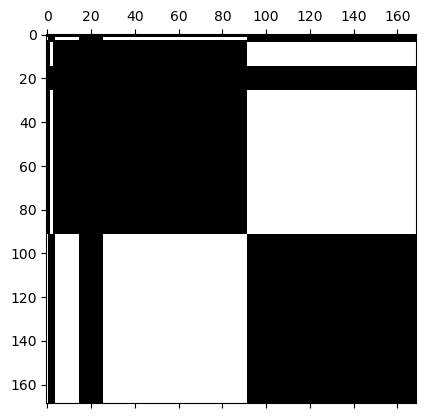

In [73]:
plt.spy(A_full)

In [74]:
# Allan FEM book: Algo 17

# Impose BC rows/cols
for i in bd_nodes:
    # incorrect
    # f_i = f_rhs(x_global[i], y_global[i])   # Dirichlet value
    # b_full -= A_full[:, i] * f_i              # adjust RHS
    # correct: in FEM book the f function are KNOWN boundary conditions -> so u_exact
    u_i = u_exact(x_global[i], y_global[i])   # Dirichlet value
    b_full = b_full - A_full[:, i] * u_i              # adjust RHS

    A_full[i, :] = 0.0
    A_full[:, i] = 0.0
    A_full[i, i] = 1.0
    # pass
    
for i in bd_nodes:
    b_full[i] = u_exact(x_global[i], y_global[i])

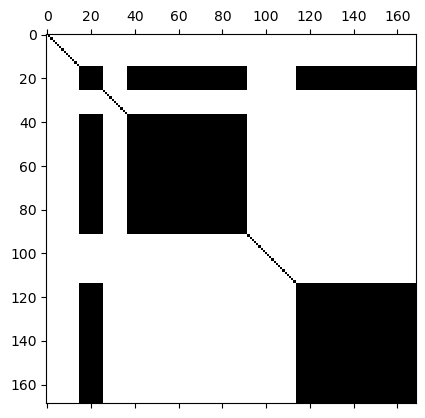

In [75]:
plt.spy(A_full)

In [76]:
u_num = linalg.solve(A_full, b_full)
u_true = u_exact(x_global, y_global)

e = u_true - u_num

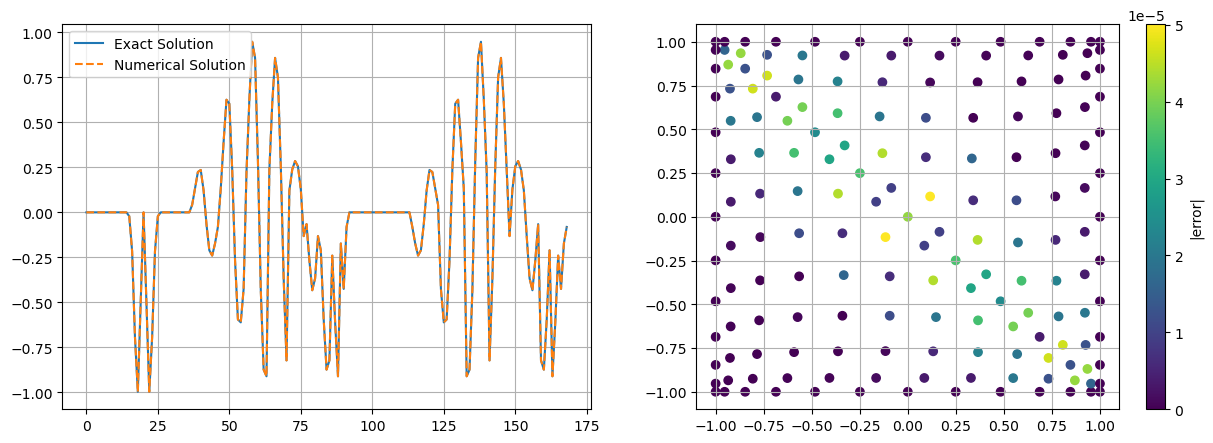

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(u_true, label="Exact Solution")
ax[0].plot(u_num, label="Numerical Solution", linestyle='--')
ax[0].legend();
ax[0].grid();

sc = ax[1].scatter(x_global, y_global, c=np.abs(e), cmap='viridis')
fig.colorbar(sc, ax=ax[1], label='|error|')
ax[1].grid();

In [ ]:
from mesh import create_2d_circle, create_toy_mesh
from discretization import create_discretization_element, create_discretization_mesh
from assignment_3.solver_bvp import BVP_Poisson_solver

In [47]:
mesh_toy = create_toy_mesh(V_x, V_y, EtoV)
discretization_element_toy = create_discretization_element(N = N)
discretization_mesh_toy = create_discretization_mesh(mesh = mesh_toy, discretization_element = discretization_element_toy)

In [48]:
bvp_poisson_solver = BVP_Poisson_solver(
    mesh = mesh_toy,
    discretization_element = discretization_element_toy,
    discretization_mesh = discretization_mesh_toy,
    f_rhs = f_rhs,
    g_bc = u_exact
)

bvp_poisson_solver.solve()

100%|██████████| 2/2 [00:00<00:00, 62.64it/s]


In [99]:
def Vandermonde2D_orthonormal(N, r, s, LocalReorder):
    a, b = rs2ab(r, s)
    num_nodes = r.shape[0]
    num_modes = (N + 1)*(N + 2)//2
    V = np.zeros((num_nodes, num_modes))
    sk = 0
    for i in range(N + 1):
        for j in range(N - i + 1):
            V[:, sk] = Simplex2DP_orthonormal(a, b, i, j)
            sk += 1
    V = V[LocalReorder, :][:, LocalReorder]
    return V

V_test = Vandermonde2D_orthonormal(N, r, s, LocalReorder = LocalReorder)

In [100]:
np.linalg.norm(V - V_test)

np.float64(226.29480166567987)

In [70]:
M_canonical - discretization_element_toy.M_canonical

array([[ 1.30104261e-18,  9.57004318e-05, -6.90290868e-05, ...,
         9.33477965e-04, -8.66015013e-04, -2.85536238e-04],
       [ 9.57004318e-05, -3.21480054e-03,  1.07534011e-04, ...,
        -1.21223752e-04, -1.39025977e-04,  1.41288524e-04],
       [-6.90290868e-05,  1.07534011e-04, -2.98277634e-02, ...,
         1.24114021e-02,  1.24114021e-02, -1.63357060e-02],
       ...,
       [ 9.33477965e-04, -1.21223752e-04,  1.24114021e-02, ...,
        -1.94059796e-02,  4.81348260e-03, -8.35000080e-04],
       [-8.66015013e-04, -1.39025977e-04,  1.24114021e-02, ...,
         4.81348260e-03, -1.94059796e-02, -8.35000080e-04],
       [-2.85536238e-04,  1.41288524e-04, -1.63357060e-02, ...,
        -8.35000080e-04, -8.35000080e-04, -2.07027156e-02]])

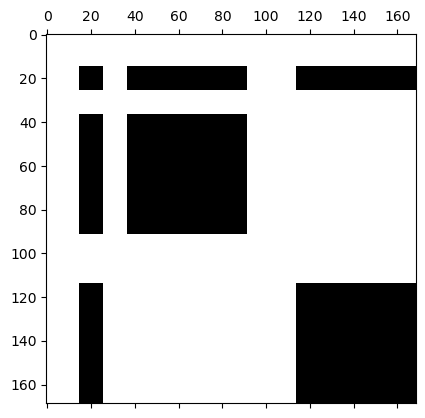

In [50]:
plt.spy(A_full - bvp_poisson_solver.L_N)

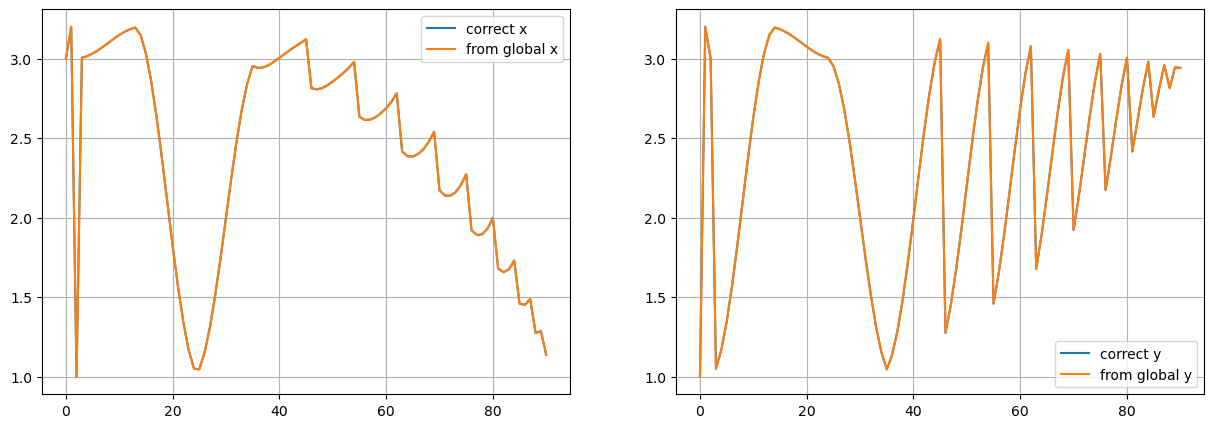

In [632]:
n_element = 1
x_1_global = x_global[C[n_element, :]]
y_1_global = y_global[C[n_element, :]]

x_vertex_n, y_vertex_n = V_x[EtoV[n_element, :]], V_y[EtoV[n_element, :]]
v1_n = np.array([x_vertex_n[0], y_vertex_n[0]])
v2_n = np.array([x_vertex_n[1], y_vertex_n[1]])
v3_n = np.array([x_vertex_n[2], y_vertex_n[2]])

x_n, y_n = Psi(r, s, v1_n, v2_n, v3_n)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x_n, label = "correct x")
ax[0].plot(x_1_global, label = "from global x")
ax[0].legend();
ax[0].grid();
ax[1].plot(y_n, label = "correct y")
ax[1].plot(y_1_global, label = "from global y")
ax[1].legend();
ax[1].grid();

## Appendix